In [67]:
import pandas as pd
import numpy as np

In [116]:
#importar dataframe do WMS
loc_itens_path = 'Desktop/TCC/GERAL/df_itens_layout2_5_10_1_100.csv'
df_localizacoes = pd.read_csv(loc_itens_path)
#importar dataframe dos pedidos
ordens_de_compra_path = 'Desktop/TCC/GERAL/df_ordens_de_compra_200.csv'
df_pedidos = pd.read_csv(ordens_de_compra_path)


In [117]:
#Identificar itens da lista de pedidos
tam_lista_de_pedidos = len(df_pedidos)
lista_de_itens = list(df_pedidos.Item)

#listas para buscar coord. dos pedidos
ls_posicao_x=[]
ls_posicao_y=[]


#Incluir coluna 'Coord' na df_lista_dos_pedidos na ordem da lista de pedidos
for i in range(tam_lista_de_pedidos):
    buscar_item = lista_de_itens[i]
    for k in range(len(df_localizacoes)):
        if buscar_item == int(df_localizacoes[k:k+1].Cod_Item):
            ls_posicao_x.append(int(df_localizacoes[k:k+1].Coord_X))
            ls_posicao_y.append(int(df_localizacoes[k:k+1].Coord_Y))
ls=list(zip(ls_posicao_x,ls_posicao_y))   
df_pedidos = df_pedidos.assign(Coord = ls)

# Separar pedidos em singulares ou multiplos:


In [118]:
# listas das colunas do df_pedidos
ls_pedidos = list(df_pedidos.ID_pedido)
ls_item = list(df_pedidos.Item)
ls_coord = list(df_pedidos.Coord)
ls_qtde = list(df_pedidos.Quant_itens)
#---------------------------------------------
#listas das colunas do df de pedidos multiplos
ls_coord_multiplos = []
ls_item_multiplos = []
ls_qtde_multiplos = []
ls_id_pedido_multiplos = []
#---------------------------------------------
#listas das colunas do df de pedidos singulares
ls_coord_singular = []
ls_item_singular = []
ls_qtde_singular = []
ls_id_pedido_singular = []
#--------------------------------------------- 
cont=0
while cont < len(ls_pedidos)-1:
    
    if ls_pedidos[cont] == ls_pedidos[cont+1]:
        
        ls_coord_multiplos.append(ls_coord[cont])
        ls_item_multiplos.append(ls_item[cont])
        ls_qtde_multiplos.append(ls_qtde[cont])
        ls_id_pedido_multiplos.append(ls_pedidos[cont])
 
        cont = cont + 1
        
        if ls_pedidos[cont] == ls_pedidos[cont-1]:
            
            ls_coord_multiplos.append(ls_coord[cont])
            ls_item_multiplos.append(ls_item[cont])
            ls_qtde_multiplos.append(ls_qtde[cont])
            ls_id_pedido_multiplos.append(ls_pedidos[cont])
          
            cont = cont + 1
    else:
        
        ls_coord_singular.append(ls_coord[cont])
        ls_item_singular.append(ls_item[cont])
        ls_qtde_singular.append(ls_qtde[cont])
        ls_id_pedido_singular.append(ls_pedidos[cont])
  
        cont = cont + 1

if ls_pedidos[len(ls_pedidos)-2] == ls_pedidos[len(ls_pedidos)-2]:
    
    ls_coord_multiplos.append(ls_coord[cont-1])
    ls_item_multiplos.append(ls_item[cont-1])
    ls_qtde_multiplos.append(ls_qtde[cont-1])
    ls_id_pedido_multiplos.append(ls_pedidos[cont-1])     
else:
    
    ls_coord_singular.append(ls_coord[cont-1])
    ls_item_singular.append(ls_item[cont-1])
    ls_qtde_singular.append(ls_qtde[cont-1])
    ls_id_pedido_singular.append(ls_pedidos[cont-1])  

df_pedidos_multiplos = pd.DataFrame(list(zip(ls_id_pedido_multiplos, ls_item_multiplos, ls_qtde_multiplos, ls_coord_multiplos)),
               columns =['ID_Pedido','Item','Qtde', 'Coord'])
df_pedidos_singulares = pd.DataFrame(list(zip(ls_id_pedido_singular, ls_item_singular, ls_qtde_singular, ls_coord_singular)),
               columns =['ID_Pedido','Item','Qtde', 'Coord'])
   

In [119]:
#Lista das coordenadas dos pedidos singulares
lista_coord = list(df_pedidos_singulares.Coord)

In [120]:
def distancia_de_busca1(u, v):
    #INCLUIR LIMITES DO ARMAZÉM 
    
    y_limite_inferior, y_limite_superior = 0, 11 
    # Start Point
    x1, y1 = u[0], u[1]
    # End Point
    x2, y2 = v[0], v[1]
    # Distance x-axis
    distancia_x = abs(x2 - x1)
    # Distance y-axis
    if x1 == x2:
        distancia_y1 = abs(y2 - y1)
        distancia_y2 = distancia_y1
    else:
        distancia_y1 = (y_limite_superior - y1) + (y_limite_superior - y2)
        distancia_y2 = (y1 - y_limite_inferior) + (y2 - y_limite_inferior)
    # Minimum distance on y-axis 
    distancia_y = min(distancia_y1, distancia_y2)    
    # Total distance
    distancia = distancia_x + distancia_y

    return distancia

In [121]:
#Criar clusters baseado no limite de distancia
#corrigido para distancia caminhada

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import ward, fcluster
#limiar da distancia para definição dos clusters
#limite_dist = 3
def cluster_locations(lista_coord, limite_dist):
    ##Distancia caminhada
    dc = pdist(lista_coord, distancia_de_busca1)
    Y = ward(dc)
    fclust1 = fcluster(Y, t = limite_dist, criterion = 'distance')
    
    ##Distancia euclidiana
    #else:
       # Z = ward(pdist(np.stack(lista_coord)))    
       # fclust1 = fcluster(Z, t = limite_dist, criterion = 'distance')
    
    
    return fclust1
#cluster_locations(lista_coord, 3)

In [122]:
#criar loop incrementando limite_dist para ajuste de limite ótimo --> Alterar limit_dist para análise
limite_dist = 11
clust_id = cluster_locations(lista_coord, limite_dist)
df_pedidos_singulares = df_pedidos_singulares.assign(Cluster_ID = clust_id)


In [123]:
df_pedidos_singulares

,ID_Pedido,Item,Qtde,Coord,Cluster_ID
0,0,94,1,"(10, 8)",3
1,1,25,1,"(4, 3)",9
2,2,21,1,"(4, 1)",9
3,3,89,1,"(10, 5)",4
4,4,47,1,"(6, 4)",10
...,...,...,...,...,...
160,192,47,1,"(6, 4)",10
161,193,72,1,"(8, 7)",2
162,196,72,1,"(8, 7)",2
163,197,59,1,"(6, 10)",5


In [124]:
#Ordenar pedidos por clusters e ID_pedido
df_pedidos_singulares = df_pedidos_singulares.sort_values(['Cluster_ID','ID_Pedido'], ascending = True)

In [125]:
df_pedidos_singulares

,ID_Pedido,Item,Qtde,Coord,Cluster_ID
5,5,62,1,"(8, 2)",1
45,51,65,1,"(8, 3)",1
94,106,65,1,"(8, 3)",1
103,123,62,1,"(8, 2)",1
121,144,62,1,"(8, 2)",1
...,...,...,...,...,...
136,163,40,1,"(6, 1)",10
144,171,47,1,"(6, 4)",10
145,172,49,1,"(6, 5)",10
154,183,48,1,"(6, 5)",10


In [126]:
#listar pedidos
list_orders = list(df_pedidos_singulares.ID_Pedido.unique())

In [127]:
#criar dicionario de pedidos key:pedido. value: contagem
dict_omap = dict(zip(list_orders, [i for i in range(1, len(list_orders)+1)]))

In [128]:
df_pedidos_singulares['OrderID'] = df_pedidos_singulares['ID_Pedido'].map(dict_omap)

In [129]:
df_pedidos_singulares

,ID_Pedido,Item,Qtde,Coord,Cluster_ID,OrderID
5,5,62,1,"(8, 2)",1,1
45,51,65,1,"(8, 3)",1,2
94,106,65,1,"(8, 3)",1,3
103,123,62,1,"(8, 2)",1,4
121,144,62,1,"(8, 2)",1,5
...,...,...,...,...,...,...
136,163,40,1,"(6, 1)",10,161
144,171,47,1,"(6, 4)",10,162
145,172,49,1,"(6, 5)",10,163
154,183,48,1,"(6, 5)",10,164


In [130]:
wave_number = 0
orders_number= 9
incr = orders_number 
list_cluster_diff = list(df_pedidos_singulares.Cluster_ID.diff())
list_wave_ID =[]

#Preenchimento de ondas até atingir numero de 'orders_number' ou mudança de Cluster_ID

for i in range(len(list_cluster_diff)):
    if (incr == 1) or (list_cluster_diff[i]):
        wave_number+=1
        list_wave_ID.append(wave_number)
        incr = incr = orders_number
    else:
        list_wave_ID.append(wave_number)
        incr -= 1
     

df_pedidos_singulares = df_pedidos_singulares.assign(WaveID = list_wave_ID)   
numero_ondas_singulares = max(df_pedidos_singulares.WaveID)
numero_ondas_singulares

23

In [131]:



def mapeamento_pedidos_singulares(orders_number, df_pedidos_singulares):
    wave_number = 0
    incr = orders_number 
    list_cluster_diff = list(df_pedidos_singulares.Cluster_ID.diff())
    list_wave_ID =[]

#Preenchimento de ondas até atingir numero de 'orders_number' ou mudança de Cluster_ID

    for i in range(len(list_cluster_diff)):
        if (incr == 1) or (list_cluster_diff[i]):
            wave_number+=1
            list_wave_ID.append(wave_number)
            incr = incr = orders_number
        else:
            list_wave_ID.append(wave_number)
            incr -= 1
    
    df_pedidos_singulares = df_pedidos_singulares.assign(WaveID = list_wave_ID)   
    numero_ondas_singulares = max(df_pedidos_singulares.WaveID)
    return df_pedidos_singulares, numero_ondas_singulares


Separar pedidos múltiplos em listas

In [132]:
df_pedidos_multiplos

,ID_Pedido,Item,Qtde,Coord
0,7,32,2,"(4, 7)"
1,7,71,2,"(8, 6)"
2,15,32,2,"(4, 7)"
3,15,36,2,"(4, 9)"
4,28,60,2,"(8, 1)"
...,...,...,...,...
64,194,99,2,"(10, 10)"
65,194,21,2,"(4, 1)"
66,195,94,2,"(10, 8)"
67,195,47,2,"(6, 4)"


In [133]:
list_orders_mult = list(df_pedidos_multiplos.ID_Pedido.unique())

In [134]:
dict_omap_mult = dict(zip(list_orders_mult, [i for i in range(1, len(list_orders_mult)+1)]))
df_pedidos_multiplos['OrderID'] = df_pedidos_multiplos['ID_Pedido'].map(dict_omap_mult)
df_pedidos_multiplos

,ID_Pedido,Item,Qtde,Coord,OrderID
0,7,32,2,"(4, 7)",1
1,7,71,2,"(8, 6)",1
2,15,32,2,"(4, 7)",2
3,15,36,2,"(4, 9)",2
4,28,60,2,"(8, 1)",3
...,...,...,...,...,...
64,194,99,2,"(10, 10)",33
65,194,21,2,"(4, 1)",33
66,195,94,2,"(10, 8)",34
67,195,47,2,"(6, 4)",34


In [135]:
def centroid(list_in):
    x, y = [p[0] for p in list_in], [p[1] for p in list_in]
    centroid = [round(sum(x) / len(list_in),2), round(sum(y) / len(list_in), 2)]
    return centroid

In [136]:
##Para cada OrderID agrupar as coord
df_mult_agrupada = pd.DataFrame(df_pedidos_multiplos.groupby(['OrderID'])['Coord'].apply(list)).reset_index()

#Calcular centroide e incluir no df
df_mult_agrupada['Coord_Centroide'] = df_mult_agrupada['Coord'].apply(centroid)

#dicionario para mapeamento
list_order, list_coord = list(df_mult_agrupada.OrderID.values), list(df_mult_agrupada.Coord_Centroide.values)
dict_coord = dict(zip(list_order, list_coord))



In [137]:
#mapeamento final
df_pedidos_multiplos['Coord_Cluster'] = df_pedidos_multiplos['OrderID'].map(dict_coord)


In [138]:
#Lista das coordenadas dos cluster dos pedidos multiplos
lista_coord_mult = list(df_pedidos_multiplos.Coord_Cluster)

In [139]:
#Incluir cluster id nos pedidos multiplos
clust_id_mult=cluster_locations(lista_coord_mult, limite_dist)
df_pedidos_multiplos = df_pedidos_multiplos.assign(Cluster_ID = clust_id_mult)

In [140]:
#ordernar pedidos multiplos por Clust ID
df_pedidos_multiplos = df_pedidos_multiplos.sort_values(['Cluster_ID','ID_Pedido'], ascending = True)

In [141]:
#listar pedidos multiplos
list_mult_orders = list(df_pedidos_multiplos.ID_Pedido.unique())

In [142]:
#criar dicionario de pedidos key:pedido. value: contagem
dict_mult_omap = dict(zip(list_mult_orders, [i for i in range(1, len(list_mult_orders)+1)]))

In [143]:
df_pedidos_multiplos['OrderID'] = df_pedidos_multiplos['ID_Pedido'].map(dict_mult_omap)

In [144]:
wave_number = numero_ondas_singulares
orders_number= 9
incr = orders_number 
list_cluster_diff_mult = list(df_pedidos_multiplos.Cluster_ID.diff())
list_wave_ID_mult =[]

#Preenchimento de ondas até atingir numero de 'orders_number' ou mudança de Cluster_ID

for i in range(len(list_cluster_diff_mult)):
    if (incr == 1) or (list_cluster_diff_mult[i]):
        wave_number+=1
        list_wave_ID_mult.append(wave_number)
        incr = incr = orders_number
    else:
        list_wave_ID_mult.append(wave_number)
        incr -= 1

#list_wave_ID_mult
    
df_pedidos_multiplos = df_pedidos_multiplos.assign(WaveID = list_wave_ID_mult)   

In [145]:

def mapeamento_pedidos_multiplos(orders_number, df_pedidos_multiplos):
    pedidos_singulares, wave_number = mapeamento_pedidos_singulares(orders_number, df_pedidos_singulares)
    incr = orders_number 
    list_cluster_diff_mult = list(df_pedidos_multiplos.Cluster_ID.diff())
    list_wave_ID_mult =[]

#Preenchimento de ondas até atingir numero de 'orders_number' ou mudança de Cluster_ID

    for i in range(len(list_cluster_diff_mult)):
        if (incr == 1) or (list_cluster_diff_mult[i]):
            wave_number+=1
            list_wave_ID_mult.append(wave_number)
            incr = incr = orders_number
        else:
            list_wave_ID_mult.append(wave_number)
            incr -= 1

#list_wave_ID_mult
    
    df_pedidos_multiplos = df_pedidos_multiplos.assign(WaveID = list_wave_ID_mult)   
    return df_pedidos_multiplos
dfpedids = mapeamento_pedidos_multiplos(orders_number, df_pedidos_multiplos)

In [146]:
def mapeamento_da_lista_de_pedidos(df_pedidos_singulares,df_pedidos_multiplos, orders_number):
    df_pedidos_singulares, tam_onda = mapeamento_pedidos_singulares(orders_number, df_pedidos_singulares)
    df_pedidos_multiplos = mapeamento_pedidos_multiplos(orders_number, df_pedidos_multiplos)
    frames = [df_pedidos_singulares, df_pedidos_multiplos]
    df_list_result = pd.concat(frames)
    df_list_result = df_list_result.drop(columns =['Coord_Cluster'])
    numero_de_ondas = max(df_list_result.WaveID)
    return df_list_result, numero_de_ondas

In [147]:
frames = [df_pedidos_singulares, df_pedidos_multiplos]
df_list_result = pd.concat(frames)

In [148]:
df_list_result = df_list_result.drop(columns =['Coord_Cluster'])

# Criar simulações de ondas coletas

In [149]:
numero_de_ondas = max(df_list_result.WaveID)


In [150]:
# Calculate Picker Route Distance between two locations
def distancia_de_busca(ponto1, ponto2, y_limite_inferior, y_limite_superior):

    # Start Point
    x1, y1 = ponto1[0], ponto1[1]
    # End Point
    x2, y2 = ponto2[0], ponto2[1]
    # Distance x-axis
    distancia_x = abs(x2 - x1)
    # Distance y-axis
    if x1 == x2:
        distancia_y1 = abs(y2 - y1)
        distancia_y2 = distancia_y1
    else:
        distancia_y1 = (y_limite_superior - y1) + (y_limite_superior - y2)
        distancia_y2 = (y1 - y_limite_inferior) + (y2 - y_limite_inferior)
    # Minimum distance on y-axis 
    distancia_y = min(distancia_y1, distancia_y2)    
    # Total distance
    distancia = distancia_x + distancia_y

    return distancia

In [151]:
def proximo_ponto(ponto_inicial, lista_localizacoes, y_limite_inferior, y_limite_superior):

    # Distance to every next points candidate
    lista_distancias = [distancia_de_busca(ponto_inicial, i, y_limite_inferior, y_limite_superior) for i in lista_localizacoes]
    # Minimum Distance 
    distancia_seguinte = min(lista_distancias)
    # Location of minimum distance
    index_min = lista_distancias.index(min(lista_distancias))
    ponto_seguinte = lista_localizacoes[index_min] # Next location is the first location with distance = min (**)
    lista_localizacoes.remove(ponto_seguinte)      # Next location is removed from the list of candidates
    
    return lista_localizacoes, ponto_inicial, ponto_seguinte, distancia_seguinte

In [152]:
def criar_rota_de_coleta(ponto_de_origem, lista_localizacoes, y_limite_inferior, y_limite_superior):

    # Total distance variable
    distancia_da_onda = 0
    # Current location variable 
    ponto_inicial = ponto_de_origem
    # Store routes
    lista_do_caminho = []
    lista_do_caminho.append(ponto_inicial)
    
    while len(lista_localizacoes) > 0: # Looping until all locations are picked
        # Going to next location
        lista_localizacoes, ponto_inicial, ponto_seguinte, distancia_seguinte = proximo_ponto(ponto_inicial, lista_localizacoes, y_limite_inferior, y_limite_superior)
        # Update ponto_inicial 
        ponto_inicial = ponto_seguinte
        lista_do_caminho.append(ponto_inicial)
        # Update distance
        distancia_da_onda = distancia_da_onda + distancia_seguinte 

    # Final distance from last storage location to origin
    distancia_da_onda = distancia_da_onda + distancia_de_busca(ponto_inicial, ponto_de_origem, y_limite_inferior, y_limite_superior)
    lista_do_caminho.append(ponto_de_origem)
    
    return distancia_da_onda, lista_do_caminho

In [153]:
def listagem_das_localizacoes(df_list_result, ID_Onda):

    # Filter by ID_Onda
    df = df_list_result[df_list_result.WaveID == ID_Onda]
    # Create coordinates listing
    lista_localizacoes = list(df['Coord'])
    lista_localizacoes.sort()
    # Get unique Unique coordinates
    #lista_localizacoes = list(k for k,_ in itertools.groupby(lista_localizacoes))
    tamanho_lista_localizacoes = len(lista_localizacoes)

    return lista_localizacoes, tamanho_lista_localizacoes




    Numero da Onda  Distancia da Rota  \
0                0                  0   
1                1                 22   
2                2                 34   
3                3                 34   
4                4                 30   
5                5                 40   
6                6                 36   
7                7                 30   
8                8                 30   
9                9                 32   
10              10                 32   
11              11                 28   
12              12                 28   
13              13                 28   
14              14                 28   
15              15                 24   
16              16                 20   
17              17                 12   
18              18                 12   
19              19                 16   
20              20                 14   
21              21                 22   
22              22                 22   
23              

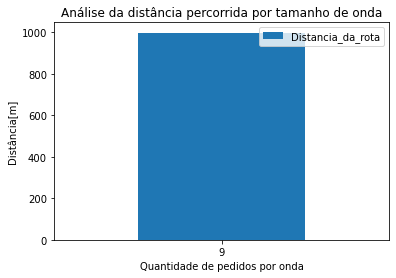

In [154]:
lista_localizacoes = df_list_result.Coord
y_limite_inferior, y_limite_superior = 0, 11 		# Alley Coordinates on y-axis
ponto_de_origem = [0, y_limite_inferior]  			# Origin Location

lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos = [], [], [], []
def onda_simulada(y_limite_inferior, y_limite_superior, tamanho_de_onda, df_list_result, lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos):
    distancia_da_rota = 0
    df_list_result, numero_de_ondas = mapeamento_da_lista_de_pedidos(df_pedidos_singulares,df_pedidos_multiplos, orders_number)
    #df_lista_dos_pedidos, numero_de_onda = mapeamento_da_lista_de_pedidos(df_pedidos_singulares,df_pedidos_multiplos, orders_number)
    for ID_Onda in range(numero_de_ondas):
            # Listing of all locations for this wave 
        lista_localizacoes, tamanho_lista_localizacoes = listagem_das_localizacoes(df_list_result, ID_Onda)
        distancia_da_onda, lista_do_caminho = criar_rota_de_coleta(ponto_de_origem, lista_localizacoes, y_limite_inferior, y_limite_superior)
        distancia_da_rota = distancia_da_rota + distancia_da_onda
        # Append lists of results 
        lista_id_da_onda.append(ID_Onda)
        lista_da_distancia.append(distancia_da_onda)
        lista_da_rota.append(lista_do_caminho)
        lista_dos_pedidos.append(tamanho_de_onda)
    return lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos, distancia_da_rota
ls_rotas = []
ls_ordens = []
# Test several values of orders per wave
lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos, distancia_da_rota = onda_simulada(y_limite_inferior, y_limite_superior, orders_number, df_list_result, lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos)
    #print("Total distance covered for {} orders/wave: {:,} m".format(tamanho_de_onda, distancia_da_rota))
ls_rotas.append(distancia_da_rota)
ls_ordens.append(orders_number)
# Create df for results
df_resultados = pd.DataFrame({'Numero da Onda': lista_id_da_onda,
               'Distancia da Rota': lista_da_distancia,
               'Caminho Percorrido': lista_da_rota,
               'Pedidos/Onda': lista_dos_pedidos})
print(df_resultados)
df_grafico = pd.DataFrame({'PedidosPorOnda':ls_ordens,
               'Distancia_da_rota':ls_rotas })
ax = df_grafico.plot.bar(x='PedidosPorOnda', y='Distancia_da_rota', rot=0, 
                         title= 'Análise da distância percorrida por tamanho de onda',
                        ylabel='Distância[m]',
                        xlabel='Quantidade de pedidos por onda')
print(ls_rotas)
#df_grafico.to_excel("analise2limiar20.xlsx")
#df_resultados.to_excel("analise2limiar20detalhada.xlsx")